# WoS dataset filtering
In this notebok, we'll address the problem of filtering out irrelevant papers from our Web of Science-generated dataset. We'll explore a few approaches to this problem, including filtering based on static and dynamic WoS keywords. We'll then evaluate our approaches on a subset of abstracts annotated for whether or not theyshould be kept or removed from the dataset (relevance labeled).

In [113]:
import jsonlines
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

## Reading in the data

In the `WoS_dataset_characterization.ipynb` notebook, I played around with using word embedding clustering to determine which keywords were relevant/irrelevant for our task. I found that while the clustering does an impressive job of grouping keywords semantically, the semantic axis on which they cluster tends to be things like scientific disciplines, chemical and protein names, all of which contain both relevant and irrelevant terms for our subject matter. Therefore, I decided to move ahead by manually labelling the keywords as relevant or not. Because the keywords are viewed in isolation of their context (i.e. without looking at the abstract that they describe), and because it's very possible that multiple papers with the same keyword are both relevant and irrelevant, it's not a guarantee that this method is any better, so we want to evaluate the method against a test set of manually labeled abstracts. We'll read in all three sets of labels here.

In [101]:
with jsonlines.open('../data/wos_files/core_collection_destol_or_anhydro_ALL_03Jan2024_sequential.jsonl') as reader:
    data = []
    for obj in reader:
        data.append(obj)

In [102]:
dynamos_ann1 = pd.read_csv('../data/wos_files/dynamic_keys_relevance_classified_27Dec2023.csv', index_col=0)
dynamos_ann2 = pd.read_csv('../data/wos_files/dynamic_keys_labeled_Ian_04Jan2024.csv', index_col=0)

In [103]:
statics_ann1 = pd.read_csv('../data/wos_files/static_keys_relevance_classified_27Dec2023.csv', index_col=0)
statics_ann2 = pd.read_csv('../data/wos_files/static_keys_labeled_Ian_04Jan2024.csv', index_col=0)

In [107]:
test_ann1 = pd.read_csv('../data/wos_files/core_collection_destol_or_anhydro_ALL_15Dec2023_3_percent_labels_ANNA.csv', index_col=0)
test_ann2 = pd.read_csv('../data/wos_files/core_collection_destol_or_anhydro_ALL_15Dec2023_3_percent_labels.csv', index_col=0)
test_ann3 = pd.read_csv('../data/wos_files/core_collection_destol_or_anhydro_ALL_15Dec2023_3_percent_labels_BOB.csv', index_col=0)

## Calculating IAA
We'll use [Cohen's kappa](https://surge-ai.medium.com/inter-annotator-agreement-an-introduction-to-cohens-kappa-statistic-dcc15ffa5ac4) for calculating this metric, which is defined as:

$$\frac{P_{o} - P_{e}}{1 - P_{e}}$$

Where $P_{o}$ is the numebr of times both raters assigned the same label, and $P_{e}$ is the probability that btoh raters would choose the same label if they guessed randomly. We'll code up a function to calculate these values to get the overall Cohen's kappa.

In [13]:
def cohens_kappa(ann1, ann2):
    """
    Compute the cohen's kappa for a set of annotations.
    
    parameters:
        ann1, df: annotator1's annotations
        ann2, df: annotator2's annotations
    
    returns:
        kappa, float: cohen's kappa
    """
    # Merge the two dfs
    anns = ann1.merge(ann2, left_index=True, right_index=True, suffixes=('_ann1', '_ann2'))
    
    # Calculate the input values
    total = len(anns)
    tp = len(anns[(anns['relevant_ann1'] == anns['relevant_ann2']) & (anns['relevant_ann1'] == 'Y')])
    tn = len(anns[(anns['relevant_ann1'] == anns['relevant_ann2']) & (anns['relevant_ann1'] == 'N')])
    fp = len(anns[(anns['relevant_ann1'] != anns['relevant_ann2']) & (anns['relevant_ann1'] == 'Y')])
    fn = len(anns[(anns['relevant_ann1'] != anns['relevant_ann2']) & (anns['relevant_ann1'] == 'N')])
    Po = (tp + tn)/total
    P1 = ((tp + fn)*(tp + fp))/total**2
    P2 = ((tn + fn) * (tn + fp))/total**2
    Pe = P1 + P2
    
    # Calculate the overall value
    kappa = (Po - Pe)/(1 - Pe)
    
    return kappa


### IAA on keywords
First, we want to calculate an IAA for our labels of the keywords. 

In [14]:
dynamo_iaa = cohens_kappa(dynamos_ann1, dynamos_ann2)
print(f'Agreement on the dynamic keywords was {dynamo_iaa:.2f}')

Agreement on the dynamic keywords was 0.10


In [15]:
static_iaa = cohens_kappa(statics_ann1, statics_ann2)
print(f'Agreement on the static keywords was {static_iaa:.2f}')

Agreement on the static keywords was 0.38


These agreements are terrible! However, with the keywords, it's important to consider the fact that, since they're completely out of context (on purpose), this is an extremely opinionated task. Potentially, one person's opinion is more correct than another's as evaluated on the test set; so for now I'm going to keep the keyword annotaions separate and treat them as separate filtering "methods".

### IAA on test set
We will also calculate the IAA for the test set -- it's more important that this be relatively high, as we want consensus, it should be less of an outright opinion task and more self-evident.

In [105]:
test_set_iaa_1_2 = cohens_kappa(test_ann1, test_ann2)
print(f'Agreement on the test set was {test_set_iaa_1_2:.2f} between annotators 1 and 2')

Agreement on the test set was 0.30 between annotators 1 and 2


In [108]:
test_set_iaa_1_3 = cohens_kappa(test_ann1, test_ann3)
print(f'Agreement on the test set was {test_set_iaa_1_3:.2f} between annotators 1 and 3')

Agreement on the test set was 0.17 between annotators 1 and 3


In [109]:
test_set_iaa_2_3 = cohens_kappa(test_ann2, test_ann3)
print(f'Agreement on the test set was {test_set_iaa_2_3:.2f} between annotators 2 and 3')

Agreement on the test set was 0.13 between annotators 2 and 3


Apparently it's not self-evident! I'd like to see if there's a difference in how "exclusive" each annotator is:

In [119]:
exclusivity = {
    'Annotator 1': test_ann1.value_counts()['N']/len(test_ann1),
    'Annotator 2': test_ann2.value_counts()['N']/len(test_ann2),
    'Annotator 3': test_ann3.value_counts()['N']/len(test_ann3)
}

Text(0.5, 1.0, 'Annotator exclusivity')

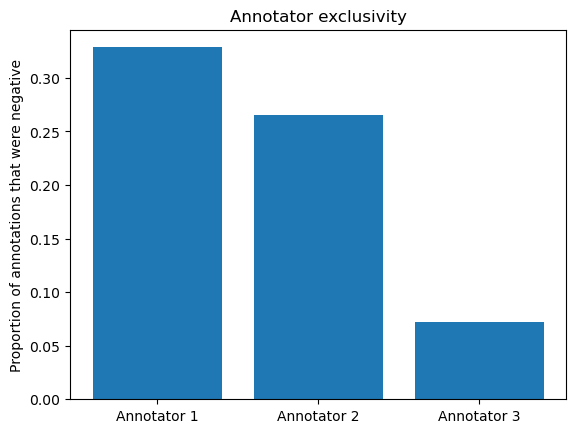

In [121]:
plt.bar(*zip(*exclusivity.items()))
plt.ylabel('Proportion of annotations that were negative')
plt.title('Annotator exclusivity')

There certainly is a marked difference! I was annotator 1, and I was the most stringent with exclusing things, versus annotator 3, who was more relaxed. Upon discussion with annotator 3, the major difference is that they included the biomedical literature on cryopreservation, only excluding paper specifically on spermatogenesis.

There is a huge amount of bias that can enter the hypothesis generation process at this stage, based on which of these philosophies we choose to move ahead with. The information contained in the papers that are excluded is lost to the downstream process of hypothesis generation, so the more exclusive (which can also be considered opinionated) the annotator is at this stage, the more their personal academic bias shows in the final dataset. Therefore, rather than unifying these annotations, I'm going to move ahead with the least exclusive of the three versions, as I think it best reflects the philosophy of trying to include as much information as possible to build better hypotheses later on.

In [122]:
test_set = test_ann3

Change Y and N to 1 and 0, respectively:

In [123]:
test_set = test_set.replace({'Y': 1, 'N': 0})

## Designing filtering methods
There are multiple of both static and dynamic keywords for most papers. Therefore, there are a few ways that we can choose to filter papers based on the classified keywords. We'll implement the following:

1. Most stringent: To keep a paper, all keywords must have Y relevance
2. Middle road: To keep a paper, the majority of keywords have Y relevance
3. Least stringent: To keep a paper, only one keyword needs a Y relevance

In [124]:
def filter_papers(papers, key_df, kind, stringency='most'):
    """
    Filter papers by keyword.
    
    parameters:
        papers, list of dict: papers to filter
        key_df, pandas df: index are keywords, column is 'relevant' containing Y or N strings
        kind, str: either 'static_keywords' or 'dynamic_keys' ## TODO change to static_keys for udpated dataset
        stringency, str: 'most', 'middle', or 'least', default is 'most'
    
    returns:
        filtered_papers, list of dict: list of papers with irrelevant papers removed
    """
    filtered_papers = []
    for paper in papers:
        # Get the relevances of all keywords
        keys = paper[kind]
        key_rels = key_df.loc[keys, :]
        # Filter based on requested stringency
        if stringency == 'most':
            if (len(key_rels['relevant'].unique()) == 1) and (key_rels['relevant'].unique()[0] == 'Y'):
                filtered_papers.append(paper)
        elif stringency == 'middle':
            nums = Counter(key_rels['relevant'].values.tolist())
            if nums['Y'] > nums['N']:
                filtered_papers.append(paper)
        elif stringency == 'least':
            if 'Y' in key_rels.relevant.values.tolist():
                filtered_papers.append(paper)
    
    return filtered_papers        

## Testing filtering methods
Now, let's see how each of these filtering methods impacts the dataset. We'll evaluate performance on the test set, and then look at how the filtering methods changes the numbers of the overall dataset.

In [125]:
def subset_papers(papers, test_set):
    """
    Pull out only the papers in the test set.
    """
    return [p for p in papers if p['UID'] in test_set.index.values.tolist()]

In [126]:
def get_f1(papers, filtered_papers, test_set):
    """
    Calculate F1 score for paper filtering method.
    
    Assumes that the same UIDs are present in papers and test_set.
    """
    yes = [p['UID'] for p in filtered_papers]
    preds = {p['UID']: (0 if p['UID'] not in yes else 1) for p in papers}
    pred_df = pd.DataFrame.from_dict(preds, orient='index', columns=['relevant'])
    
    together = test_set.merge(pred_df, left_index=True, right_index=True, suffixes=('_test', '_pred'))
    
    return f1_score(together.relevant_test, together.relevant_pred)

In [127]:
def generate_confusion_matrix(papers, filtered_papers, test_set):
    """
    Generate confusion matrix for paper relevance classification.
    """
    yes = [p['UID'] for p in filtered_papers]
    preds = {p['UID']: (0 if p['UID'] not in yes else 1) for p in papers}
    pred_df = pd.DataFrame.from_dict(preds, orient='index', columns=['relevant'])
    
    together = test_set.merge(pred_df, left_index=True, right_index=True, suffixes=('_test', '_pred'))
    
    return confusion_matrix(together.relevant_test, together.relevant_pred)

In [128]:
papers_for_eval = subset_papers(data, test_set)

### Dynamic keywords

In [129]:
for string in ['most', 'middle', 'least']:
    for annr, anns in {'annotator 1': dynamos_ann1, 'annotator 2': dynamos_ann2}.items():
        filtered_papers = filter_papers(papers_for_eval, anns, 'dynamic_keys', stringency=string)
        f1 = get_f1(papers_for_eval, filtered_papers, test_set)
        print(f'The F1 score for {string} stringency with {annr}\'s dynamic key labels is {f1:.2f}')

The F1 score for most stringency with annotator 1's dynamic key labels is 0.67
The F1 score for most stringency with annotator 2's dynamic key labels is 0.00
The F1 score for middle stringency with annotator 1's dynamic key labels is 0.89
The F1 score for middle stringency with annotator 2's dynamic key labels is 0.03
The F1 score for least stringency with annotator 1's dynamic key labels is 0.93
The F1 score for least stringency with annotator 2's dynamic key labels is 0.66


In [130]:
most_dynamo = filter_papers(data, dynamos_ann1, 'dynamic_keys')
print(f'{len(most_dynamo)} of {len(data)} were kept upon filtering.')

4044 of 6903 were kept upon filtering.


In [131]:
middle_dynamo = filter_papers(data, dynamos_ann1, 'dynamic_keys', stringency='middle')
print(f'{len(middle_dynamo)} of {len(data)} were kept upon filtering.')

5796 of 6903 were kept upon filtering.


In [132]:
least_dynamo = filter_papers(data, dynamos_ann1, 'dynamic_keys', stringency='least')
print(f'{len(least_dynamo)} of {len(data)} were kept upon filtering.')

6380 of 6903 were kept upon filtering.


### Static keywords

In [133]:
for string in ['most', 'middle', 'least']:
    for annr, anns in {'annotator 1': statics_ann1, 'annotator 2': statics_ann2}.items():
        filtered_papers = filter_papers(papers_for_eval, anns, 'static_keys', stringency=string)
        f1 = get_f1(papers_for_eval, filtered_papers, test_set)
        print(f'The F1 score for {string} stringency with {annr}\'s static key labels is {f1:.2f}')

The F1 score for most stringency with annotator 1's static key labels is 0.73
The F1 score for most stringency with annotator 2's static key labels is 0.13
The F1 score for middle stringency with annotator 1's static key labels is 0.81
The F1 score for middle stringency with annotator 2's static key labels is 0.24
The F1 score for least stringency with annotator 1's static key labels is 0.90
The F1 score for least stringency with annotator 2's static key labels is 0.52


In [134]:
most_static = filter_papers(data, statics_ann1, 'static_keys')
print(f'{len(most_static)} of {len(data)} were kept upon filtering.')

3978 of 6903 were kept upon filtering.


In [135]:
middle_static = filter_papers(data, statics_ann1, 'static_keys', stringency='middle')
print(f'{len(middle_static)} of {len(data)} were kept upon filtering.')

4692 of 6903 were kept upon filtering.


In [136]:
least_static = filter_papers(data, statics_ann1, 'static_keys', stringency='least')
print(f'{len(least_static)} of {len(data)} were kept upon filtering.')

5963 of 6903 were kept upon filtering.


#### Outcomes
Ian's labels are too strict, and result in poor performance compared to mine; they also show more variation across the stringencies than mine do. The highest absolute F1 is 0.93 with dynamic keys and least stringency, but that is not necessarily meaningfully different from the 0.90 on least stringent static. It's clear from the difference in the number of papers included in the final overall dataset for each method that one or the other favors false negatives versus false positives; I'd rather have more false negatives than false positives, so I'll make some confusion matrices here to help decide.

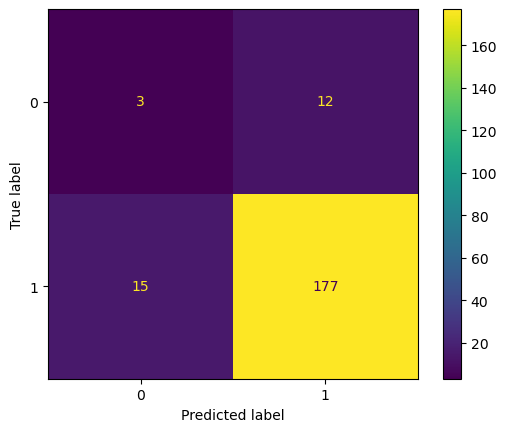

In [137]:
filtered_papers = filter_papers(papers_for_eval, dynamos_ann1, 'dynamic_keys', stringency='least')
cm = generate_confusion_matrix(papers_for_eval, filtered_papers, test_set)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

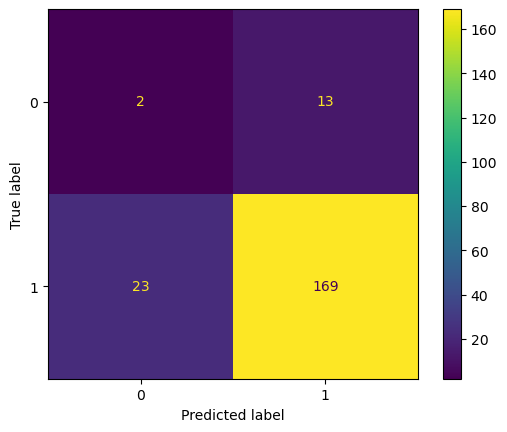

In [138]:
filtered_papers = filter_papers(papers_for_eval, statics_ann1, 'static_keys', stringency='least')
cm = generate_confusion_matrix(papers_for_eval, filtered_papers, test_set)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

These don't look different, which to me implies that my test set may not be representative of the overall dataset in terms of what keywords are present; it might have been prudent to select test documents stratifying on keywords rather than randomly. However, for the moment, we'll move ahead with this test set, and I'm going to select the static keyword filtering method, as it's smaller and I would imagine therefore that it's biased towards false negatives as I would prefer, rather than the opposite.

In [99]:
len(least_static)

5963

In [98]:
with jsonlines.open('../data/wos_files/core_collection_destol_or_anhydro_FILTERED_05Jan2023.jsonl', 'w') as writer:
    writer.write_all(least_static)